In [18]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model
new_model = load_model('DigitRecognizerModel.h5')

def prediction(test_image):
    
    classes = new_model.predict_classes(test_image)
    
    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

#creating a function to get the different position of cells
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img,(252,252))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = width//9
    cell_height = height//9
    
    x1,x2,y1,y2 = 0,0,0,0
    
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions


#using the trained model to predict the digits in each cell, if cell is empty fix with 0
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        #img1 = img[4:25,5:23]
        #22-3-2020
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        img1 = tf.cast(img1, tf.float32) #for linux (tf2.0)

        result = prediction(img1)
        
    return result

def extractSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    cell_digits,num = [],0
    cells = getCellPositions(img_PT)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

In [19]:
#Taking the image
img = cv2.imread('easy2.png')

In [20]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray,cmap='gray')

dst = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT)
#plt.imshow(dst,cmap='gray')

ret,thresh_inv = cv2.threshold(gray, 180, 255,cv2.THRESH_BINARY_INV)
#plt.imshow(thresh_inv,cmap='gray')

minLineLength = 100
maxLineGap = 60
lines = cv2.HoughLinesP(thresh_inv,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for l in lines:
    x1,y1,x2,y2 = l[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2, cv2.LINE_AA)

#Save the image 
cv2.imwrite('hough.jpg',img)

img_hough = cv2.imread('hough.jpg',0)
img_show = cv2.imread('hough.jpg')
#plt.imshow(img_show, cmap='gray')

contours,hierarchy = cv2.findContours(img_hough,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# find the biggest area
cnt = contours[0]
max_area = cv2.contourArea(cnt)

for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

epsilon = 0.01*cv2.arcLength(cnt,True)
poly_approx = cv2.approxPolyDP(cnt, epsilon, True)

#function that takes in points
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [0, maxHeight - 1],
        [maxWidth - 1, maxHeight - 1],
        [maxWidth - 1, 0]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

img_PT = four_point_transform(thresh_inv,poly_approx)
#plt.imshow(img_PT, cmap='gray')

#Save the image named img_PT
cv2.imwrite('img_PT.jpg',img)

a = extractSudokuDigits(img_PT)
#a

b = []
for i in range(9):
  for j in range(9):
    c = a[i][j]
    b.append(c)

s = np.array(b) 
#s

p = ""
for i in range(81):
  p += str(s[i])

#p

from IPython.display import clear_output
from basicNeeds import display

sudoko = p #input("Enter the puzzle(' . ' for every blank space): \n")

clear_output(wait=True)
print('\n',"Input: ")



# Encoding the rows and columns in short creating labels 
rows = 'ABCDEFGHI'
columns = '123456789'

def cross(a, b): #join all letters from a(rows) with all letters of b(columns)
    return [s + t for s in a for t in b]
boxes = cross(rows, columns)

row_units = [cross(row, columns) for row in rows]
column_units = [cross(rows, column) for column in columns]
square_units = [
    cross(rs, cs) 
    for rs in ('ABC', 'DEF', 'GHI')
    for cs in ('123', '456', '789')
]

unitlist = row_units + column_units + square_units
units = dict((box, [unit for unit in unitlist if box in unit]) for box in boxes)

# Creating peers 
# A peers is a box that belongs to the same row, column or 3x3 square

peers = dict((box, set(sum(units[box], [])) - set([box])) for box in boxes)

def grid_values(grid): #Converting grid string into {<box> : <value>} dict with '.' value for empty entries.

    return dict(zip(boxes, grid))

# Taking entry of suduko grid
sudoku_string = sudoko + '\n'
sudoku_dict = grid_values(sudoku_string)

# Displaying our Sudoku 

display(sudoku_dict)



 Input: 
5 3 0 |0 7 0 |0 0 0 
6 0 0 |1 9 5 |0 0 0 
0 9 8 |0 0 0 |0 6 0 
------+------+------
8 0 0 |0 6 0 |0 0 0 
4 0 0 |8 0 0 |0 0 1 
7 0 0 |0 2 0 |0 0 6 
------+------+------
0 6 0 |0 0 0 |2 8 0 
0 0 0 |4 1 9 |0 0 5 
0 0 0 |0 8 0 |0 7 9 


In [21]:
def checkForCorrection():
  i = 0
  j = 0
  change = input("Enter the location where you want to change for a[0][0] as first small grid: ")
  i = int(change[2])
  j = int(change[5])
  print("Element in the pointed location is: ", a[i][j])
  replacement = int(input("Enter the correct integer: "))
  a[i][j] = replacement

repitetion = 1
while True:
  print("Do you want to change any number from the grid: ")
  check = input()
  if check == 'yes':
    checkForCorrection()
  else:
    break
  

b = []
for i in range(9):
  for j in range(9):
    c = a[i][j]
    b.append(c)

s = np.array(b) 
p = ""
for i in range(81):
  p += str(s[i])

# Taking entry of suduko grid
sudoku_string = p + '\n'
sudoku_dict = grid_values(sudoku_string)

# Displaying our Sudoku 

display(sudoku_dict)



Do you want to change any number from the grid: 
yes
Enter the location where you want to change for a[0][0] as first small grid: a[3][8]
Element in the pointed location is:  0
Enter the correct integer: 3
Do you want to change any number from the grid: 
yes
Enter the location where you want to change for a[0][0] as first small grid: a[4][5]
Element in the pointed location is:  0
Enter the correct integer: 3
Do you want to change any number from the grid: 
no
5 3 0 |0 7 0 |0 0 0 
6 0 0 |1 9 5 |0 0 0 
0 9 8 |0 0 0 |0 6 0 
------+------+------
8 0 0 |0 6 0 |0 0 3 
4 0 0 |8 0 3 |0 0 1 
7 0 0 |0 2 0 |0 0 6 
------+------+------
0 6 0 |0 0 0 |2 8 0 
0 0 0 |4 1 9 |0 0 5 
0 0 0 |0 8 0 |0 7 9 


In [22]:
from basicNeeds import display

sudoko = p #input("Enter the puzzle(' . ' for every blank space): \n")

# Encoding the rows and columns in short creating labels 
rows = 'ABCDEFGHI'
columns = '123456789'

def cross(a, b): #join all letters from a(rows) with all letters of b(columns)
    return [s + t for s in a for t in b]
boxes = cross(rows, columns)

row_units = [cross(row, columns) for row in rows]
column_units = [cross(rows, column) for column in columns]
square_units = [
    cross(rs, cs) 
    for rs in ('ABC', 'DEF', 'GHI')
    for cs in ('123', '456', '789')
]

unitlist = row_units + column_units + square_units
units = dict((box, [unit for unit in unitlist if box in unit]) for box in boxes)

# Creating peers 
# A peers is a box that belongs to the same row, column or 3x3 square

peers = dict((box, set(sum(units[box], [])) - set([box])) for box in boxes)

def grid_values(grid): #Converting grid string into {<box> : <value>} dict with '.' value for empty entries.

    return dict(zip(boxes, grid))

# Taking entry of suduko grid
sudoku_string = sudoko + '\n'
sudoku_dict = grid_values(sudoku_string)

# Displaying our Sudoku 

#display(sudoku_dict)

def grid_values(grid): # Updating our grid_values function to encode every empty box with '123456789' instead of '.'.
    new_grid = ['123456789' if value == '0' else value for value in grid]
    return dict(zip(boxes, new_grid))

sudoku_string = sudoko
sudoku_dict = grid_values(sudoku_string)


# Now implimenting the elemination

"""Eliminate values from peers of each box with a single value.

    Go through all the boxes, and whenever there is a box with a single value,
    eliminate this value from the set of values of all its peers.

    Arguments:
        values: Sudoku in dictionary form.
    Returns:
        Resulting Sudoku in dictionary form after eliminating values.
"""

def eliminate(grid):
    solved_boxes = [box for box in grid.keys() if len(grid[box]) == 1]
    for box in solved_boxes:
        digit = grid[box]
        for peer in peers[box]:
            grid[peer] = grid[peer].replace(digit, '')
    return grid

sudoku_string = sudoko
sudoku_dict = eliminate(grid_values(sudoku_string))


"""
    Finalize all values that are the only choice for a unit.

    Go through all the units, and whenever there is a unit with a value
    that only fits in one box, assign the value to this box.

    Input: Sudoku in dictionary form.
    Output: Resulting Sudoku in dictionary form after filling in only choices.
    
"""

def only_choice(grid):
    for unit in unitlist:
        for digit in '123456789': 
            digit_places = [box for box in unit if digit in grid[box]]
            if len(digit_places) == 1:
                grid[digit_places[0]] = digit
    return grid

sudoku_string = sudoko
sudoku_dict = only_choice(eliminate(grid_values(sudoku_string)))


# Using Constraint Propagation
'''
    Constrain propagations is all about to use local constraints in a space to reduce the
    search space. In the case of of Sudoku, each box have some conditions that help
    us to reduce the search space. We used those conditions to implement the
    functions eliminate and only_choices.
'''

def reduce_puzzle(grid):
    stalled = False
    while not stalled:
        # Check how many boxes have a determined value
        solved_values_before = len([box for box in grid.keys() if len(grid[box]) == 1])

        # Use the Eliminate Strategy
        grid = eliminate(grid)

        # Use the Only Choice Strategy
        grid = only_choice(grid)

        # Checking how many boxes have a determined value, to compare
        solved_values_after = len([box for box in grid.keys() if len(grid[box]) == 1])
        
        # If no new values were added, stop the loop.
        stalled = solved_values_before == solved_values_after
        
        # Sanity check, return False if there is a box with zero available values:
        if len([box for box in grid.keys() if len(grid[box]) == 0]):
            return False
        
    return grid

sudoku_string = sudoko
sudoku_dict = reduce_puzzle(grid_values(sudoku_string))


# neural network part
# We will start with a box with a minimal number of possible values. We will create a search tree of possibilities and traverse it using DFS untils it finds a solution

def search(grid): # Using depth-first search and propagation, try all possible values.
    
    # First, reduce the puzzle using the previous function
    grid = reduce_puzzle(grid)
    if grid is False:
        return False  # Failed earlier
    if all(len(grid[box]) == 1 for box in boxes):
        return grid  # Solved!
    
    # Choose one of the unfilled squares with the fewest possibilities
    _, box = min(
        (len(grid[box]), box)
        for box in boxes if len(grid[box]) > 1
    )

    # Now use recurrence to solve each one of the resulting sudokus
    for value in grid[box]:
        new_sudoku = grid.copy()
        new_sudoku[box] = value
        attempt = search(new_sudoku)
        if attempt:
            return attempt
        
        
print("\n\n","Solution: ")
harder_sudoku_string = sudoko #'.....9....4.........67...42..54.6.9.8...2..37...3...85.9..78.543..1.27...........'
                       #         ........................................1........................................
harder_sudoku_dict = grid_values(harder_sudoku_string)
display(search(harder_sudoku_dict))



 Solution: 
5 3 4 |6 7 8 |9 1 2 
6 7 2 |1 9 5 |3 4 8 
1 9 8 |3 4 2 |5 6 7 
------+------+------
8 5 9 |7 6 1 |4 2 3 
4 2 6 |8 5 3 |7 9 1 
7 1 3 |9 2 4 |8 5 6 
------+------+------
9 6 1 |5 3 7 |2 8 4 
2 8 7 |4 1 9 |6 3 5 
3 4 5 |2 8 6 |1 7 9 


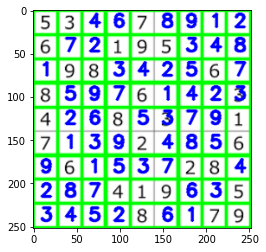

In [23]:
#helper function to get the empty cells
def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)
    return None

#helper function to validate placement of new digits in empty cells
def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

#looking for the empty cells and returning
def detectEmptyCell(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:    
        return pos
    else:
        return 0

#placing the valid digits for the puzzle in the empty cells and visualizing
def placeSudokuDigits(img_PT):
    #we start looking at the middle of the cell as this is where the sudoku digit should be at
    img_PT = cv2.resize(img_PT,(252,252)) #had to reshape the image size to fit the model shape
    img_color = cv2.resize(img,(252,252))
    cells = getCellPositions(img_PT)
    n = 9
    cr = [cells[i:i+n] for i in range(0, len(cells), n)] #cr meaning cells reshaped
    digits = extractSudokuDigits(img_PT)
    solve(digits) 
    for i in range(len(cr)):
        for j in range(len(cr[i])):
            pos = detectEmptyCell(cr[i][j],img_PT)
            digit_text = a[i][j]
            if pos == []:
                cv2.putText(img_color, str(digit_text), ((cr[i][j][0]+8),(cr[i][j][2]+19)),cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                continue  
    plt.imshow(img_color,cmap='gray')
    cv2.imwrite("solution.jpg", img_PT)

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")
                
#displaying our sudoku board in its array format (digit 0 represents empty cells)             
#print_board(a)

#using the function to solve digits extracted from the image
#print_board(a)
print('\n')
solve(a)
#print_board(a)
placeSudokuDigits(img_PT)
